In [23]:
# Import required libraries
import os
import subprocess
import getpass
import pandas as pd
import matplotlib.pyplot as plt
import re
from jiwer import wer
from playsound import playsound
from pydub import AudioSegment
from pydub.playback import play

In [24]:
# Define paths
kaldi_timit_path = r"C:\Users\DELL 5540\Desktop\ASR\kaldi\egs\timit\s5"  # Path to Kaldi TIMIT folder
audio_test_path = r"C:\Users\DELL 5540\Desktop\ASR\archive (3)\data\TEST"  # Path to test audio files

# Change the current working directory to the Kaldi TIMIT folder
os.chdir(kaldi_timit_path)
print("Changed working directory to:", os.getcwd())

Changed working directory to: C:\Users\DELL 5540\Desktop\ASR\kaldi\egs\timit\s5


Results output:
#!/bin/bash
for x in exp/{mono,tri,sgmm,dnn,combine}*/decode*; do [ -d $x ] && echo $x | grep "${1:-.*}" >/dev/null && grep WER $x/wer_* 2>/dev/null | utils/best_wer.sh; done
for x in exp/{mono,tri,sgmm,dnn,combine}*/decode*; do [ -d $x ] && echo $x | grep "${1:-.*}" >/dev/null && grep Sum $x/score_*/*.sys 2>/dev/null | utils/best_wer.sh; done
exit 0

# Use caution when comparing these results with other published results.
Training Set   : 3696 sentences 4620 sentences
Dev Set        : 400 sentences
Test Set       : 192 sentences Core Test Set (different from Full 1680 sent. set)
Language Model : Bigram phoneme language model which is extracted from training set
Phone mapping  : Training with 48 phonemes, for testing mapped to 39 phonemes


# monophone, deltas.
---------------------------------Dev Set------------------------------------------
%WER 31.7 | 400 15057 | 71.8 19.5 8.7 3.5 31.7 100.0 | -0.457 | exp/mono/decode_dev/score_5/ctm_39phn.filt.sys
------------------

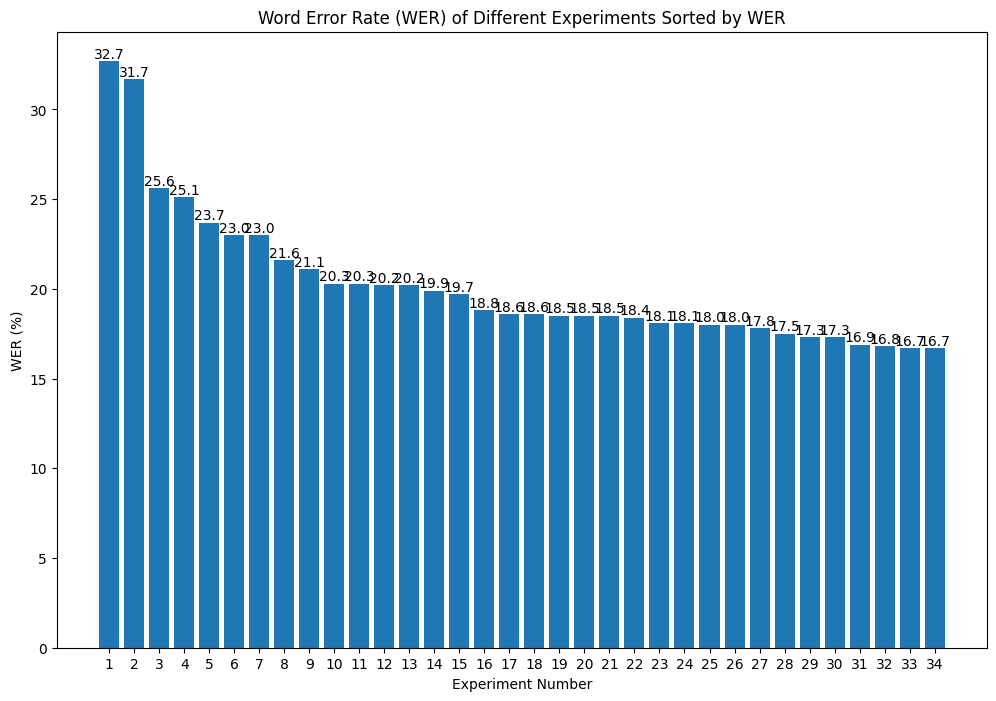

In [25]:
def get_results():
    """
    Reads the RESULTS file and returns its output as a list of lines.
    """
    results_path = os.path.join(kaldi_timit_path, "RESULTS")
    try:
        with open(results_path, "r") as f:
            lines = f.read().strip().splitlines()
        return lines
    except Exception as e:
        print("Error reading RESULTS file:", e)
        return []

results_output = get_results()
print("Results output:")
print("\n".join(results_output))

# Parse the output into lists
wers = []
params = []
times = []
paths = []

for line in results_output:
    parts = line.split('|')
    if len(parts) >= 5:
        wers.append(parts[0].strip())
        params.append(parts[1].strip())
        times.append(parts[3].strip())
        paths.append(parts[4].strip())

# Create a DataFrame
df = pd.DataFrame({
    'WER': wers,
    'Parameters': params,
    'Time Taken': times,
    'Result Path': paths
})

# Ensure the 'WER' column is of type string before using .str accessor
df['WER'] = df['WER'].astype(str)

# Convert WER to numeric values (strip the '%WER' text)
df['WER'] = pd.to_numeric(df['WER'].str.replace('%WER', '').str.strip(), errors='coerce')

# Sort the DataFrame by WER (descending order) and plot the results
df_sorted = df.sort_values('WER', ascending=False).reset_index(drop=True)
plt.figure(figsize=(12, 8))
bars = plt.bar(df_sorted.index, df_sorted['WER'])

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

plt.xlabel('Experiment Number')
plt.ylabel('WER (%)')
plt.title('Word Error Rate (WER) of Different Experiments Sorted by WER')
plt.xticks(df_sorted.index, df_sorted.index + 1)
plt.show()

In [26]:
def convert_to_wav(input_file, output_file):
    """
    Converts an audio file to WAV format using ffmpeg.
    """
    command = f'ffmpeg -y -i "{input_file}" "{output_file}"'
    try:
        result = subprocess.run(command, shell=True, capture_output=True, text=True)
        if result.returncode == 0:
            print("* The command was successful.")
            if result.stderr:
                print(result.stderr)
        else:
            print("* An error occurred:")
            print(result.stderr)
    except Exception as e:
        print("Error in convert_to_wav:", e)

def speech_recognition(audio_file):
    """
    Runs the speech recognition script on the provided audio file and saves the output to out.txt.
    """
    try:
        # Run the main.py script
        python_command = "python"  # Use "python" or the full path to python.exe if needed.
        script_name = "main.py"
        command = f"{python_command} {script_name} {audio_file}"
        result = subprocess.run(command.split(), capture_output=True, text=True)
        
        # Check for errors
        if result.stderr:
            print("Error:", result.stderr)
        else:
            # Read the generated transcript from out.txt
            with open("out.txt", "r") as f:
                transcript = f.read()
            print("Generated Transcript:", transcript)
    except Exception as e:
        print("Error executing speech_recognition:", e)

def calculate_word_error_rate(original_text, generated_text):
    """
    Calculates the Word Error Rate (WER) between two strings.
    """
    original_text = original_text.lower()
    generated_text = generated_text.lower()
    original_text = re.sub(r'[^\w\s]', '', original_text)
    generated_text = re.sub(r'[^\w\s]', '', generated_text)
    percentage_wer = wer(original_text, generated_text) * 100
    final_value = round(percentage_wer, 2)
    return f"{final_value}%"

In [27]:
# Test the model on a sample audio file
input_file = os.path.join(audio_test_path, r"C:\Users\DELL 5540\Desktop\ASR\archive (3)\data\TEST\DR1\FAKS0\SA1.WAV")
output_file = os.path.join(audio_test_path, r"C:\Users\DELL 5540\Desktop\ASR\ConvertedSample1.wav")

# Convert to WAV format
convert_to_wav(input_file, output_file)

# Play the audio
audio = AudioSegment.from_wav(output_file)
play(audio)

# Run speech recognition
speech_recognition(output_file)

* The command was successful.
ffmpeg version 2025-02-17-git-b92577405b-essentials_build-www.gyan.dev Copyright (c) 2000-2025 the FFmpeg developers
  built with gcc 14.2.0 (Rev1, Built by MSYS2 project)
  configuration: --enable-gpl --enable-version3 --enable-static --disable-w32threads --disable-autodetect --enable-fontconfig --enable-iconv --enable-gnutls --enable-libxml2 --enable-gmp --enable-bzlib --enable-lzma --enable-zlib --enable-libsrt --enable-libssh --enable-libzmq --enable-avisynth --enable-sdl2 --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxvid --enable-libaom --enable-libopenjpeg --enable-libvpx --enable-mediafoundation --enable-libass --enable-libfreetype --enable-libfribidi --enable-libharfbuzz --enable-libvidstab --enable-libvmaf --enable-libzimg --enable-amf --enable-cuda-llvm --enable-cuvid --enable-dxva2 --enable-d3d11va --enable-d3d12va --enable-ffnvcodec --enable-libvpl --enable-nvdec --enable-nvenc --enable-vaapi --enable-libgme --enable-libopenmp